In [1]:
import torch

In [ ]:
torch.__version__

'2.5.1+cu124'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



Evaluating dataset: 20 Newsgroups
Accuracy on 20 Newsgroups: 0.7133
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       236
           1       0.69      0.70      0.70       287
           2       0.71      0.67      0.69       290
           3       0.61      0.65      0.63       285
           4       0.78      0.67      0.72       312
           5       0.83      0.77      0.80       308
           6       0.72      0.68      0.70       276
           7       0.78      0.70      0.74       304
           8       0.47      0.82      0.59       279
           9       0.84      0.84      0.84       308
          10       0.93      0.87      0.90       309
          11       0.88      0.75      0.81       290
          12       0.59      0.68      0.63       304
          13       0.79      0.83      0.81       300
          14       0.78      0.77      0.77       297
          15       0.67      0.78      0.72

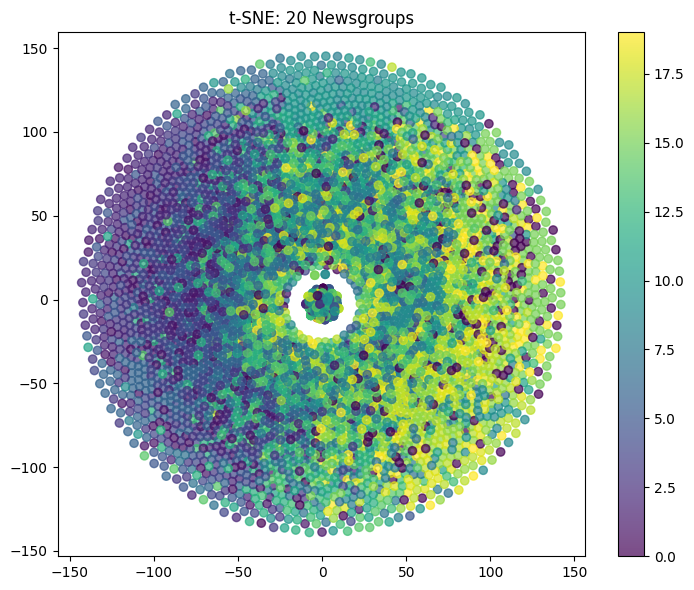


Running concept drift detection on selected dataset...


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For classification and t-SNE evaluation
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE

# For concept drift detection
import networkx as nx
from networkx.generators.random_graphs import barabasi_albert_graph
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required nltk data (if not already available)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#############################
# Part 1: Classification & t-SNE Evaluation
#############################

def evaluate_and_visualize(data, labels, dataset_name, random_state=42):
    """
    Converts text to TF-IDF features, splits into train and test sets, trains a
    Logistic Regression classifier, prints evaluation metrics, and computes a
    t-SNE embedding for visualization.

    Returns a dictionary with the t-SNE embedding, true test labels, accuracy,
    and classification report.
    """
    print(f"\nEvaluating dataset: {dataset_name}")

    # Vectorize text data with TF-IDF
    vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
    X = vectorizer.fit_transform(data)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size=0.3, random_state=random_state)

    # Train a Logistic Regression classifier
    clf = LogisticRegression(max_iter=1000, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Evaluate performance
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Accuracy on {dataset_name}: {acc:.4f}")
    print("Classification Report:")
    print(report)

    # t-SNE: reduce high-dimensional TF-IDF features to 2D (requires dense array)
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=30)
    # Use toarray() to convert to a standard NumPy array (avoiding np.matrix)
    X_test_dense = X_test.toarray()
    X_embedded = tsne.fit_transform(X_test_dense)

    return {"tsne": X_embedded, "y_test": y_test, "accuracy": acc, "report": report}

#############################
# Part 2: Concept Drift Detection (Preserving Original Logic)
#############################

def initialize_graph():
    # Create an initial scale-free network using the Barabási-Albert model.
    return barabasi_albert_graph(100, 2)

def extract_keywords(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens

def train_word2vec(texts):
    sentences = [extract_keywords(text) for text in texts]
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    return model

def keyword_similarity(keyword1, keyword2, word2vec_model):
    if keyword1 in word2vec_model.wv and keyword2 in word2vec_model.wv:
        return word2vec_model.wv.similarity(keyword1, keyword2)
    else:
        return 0  # If one of the keywords is not in the vocabulary, return 0 similarity

def update_graph(graph, text, word2vec_model, decay_factor, threshold):
    keywords = extract_keywords(text)
    # Apply decay to existing edges
    for edge in list(graph.edges(data=True)):
        if 'weight' in edge[2] and edge[2]['weight'] > decay_factor:
            edge[2]['weight'] -= decay_factor
        else:
            graph.remove_edge(edge[0], edge[1])
    # Add new edges from the current text
    for keyword in keywords:
        if not graph.has_node(keyword):
            graph.add_node(keyword)
        for node in list(graph.nodes()):
            if keyword != node:
                similarity = keyword_similarity(keyword, node, word2vec_model)
                if similarity > threshold:  # Only add if similarity exceeds threshold
                    if graph.has_edge(keyword, node):
                        graph[keyword][node]['weight'] += similarity
                    else:
                        graph.add_edge(keyword, node, weight=similarity)

def community_detection(graph):
    communities = list(nx.algorithms.community.label_propagation_communities(graph))
    return communities

def calculate_assortativity(graph):
    try:
        return nx.degree_assortativity_coefficient(graph)
    except Exception:
        return 0

def detect_drift(prev_communities, current_communities, assortativity_list):
    # Detect drift if the number of communities changes or if communities differ significantly.
    if len(prev_communities) != len(current_communities):
        return True
    for prev_community in prev_communities:
        found_match = False
        for current_community in current_communities:
            if len(set(prev_community).intersection(current_community)) / len(set(prev_community)) >= 0.7:
                found_match = True
                break
        if not found_match:
            return True
    return False

def plot_line_chart(num_communities_list, concept_drift_points, total_instances, assortativity_list):
    # Plot number of communities over time
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, total_instances + 1), num_communities_list[:total_instances], marker='o', linestyle='-', label='Number of Communities')
    plt.xlabel('Time')
    plt.ylabel('Number of Communities')
    plt.title('Concept Drift Detection: Community Count')
    for point in concept_drift_points:
        plt.scatter(point, num_communities_list[point-1], color='red', zorder=5, s=50)
    plt.legend()
    plt.savefig("concept_drift_communities.png")
    plt.show()

    # Plot assortativity over time
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, total_instances + 1), assortativity_list[:total_instances], marker='x', linestyle='-', label='Degree Assortativity')
    plt.xlabel('Time')
    plt.ylabel('Degree Assortativity')
    plt.title('Concept Drift Detection: Assortativity Over Time')
    plt.legend()
    plt.savefig("concept_drift_assortativity.png")
    plt.show()

def concept_drift_detection_decay(texts, change_point_after, decay_factor, threshold):
    """
    Detects concept drift using a decay mechanism. The function updates a scale-free graph
    with new text inputs, detects community changes over time, and calculates the degree assortativity.
    It plots the number of communities and assortativity over time.
    """
    graph = initialize_graph()
    word2vec_model = train_word2vec(texts)
    prev_communities = None
    num_communities_list = []  # Store number of communities per time step
    concept_drift_points = []  # Store detected drift time steps
    assortativity_list = []  # Store assortativity values over time

    for i, text in enumerate(texts):
        update_graph(graph, text, word2vec_model, decay_factor, threshold)
        current_communities = community_detection(graph)
        num_communities = len(current_communities)
        num_communities_list.append(num_communities)
        assortativity = calculate_assortativity(graph)
        assortativity_list.append(assortativity)
        if prev_communities is not None and detect_drift(prev_communities, current_communities, assortativity_list):
            concept_drift_points.append(i)
        if (i + 1) % change_point_after == 0:
            plot_line_chart(num_communities_list, concept_drift_points, i + 1, assortativity_list)
        prev_communities = current_communities

    plot_line_chart(num_communities_list, concept_drift_points, len(texts), assortativity_list)
    return num_communities_list, concept_drift_points

#############################
# Main: Integrate Both Evaluations & Detection
#############################

def main():
    results = {}
    # ---------------------------
    # Evaluate on 20 Newsgroups Dataset
    # ---------------------------
    newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    data_20 = newsgroups.data
    labels_20 = newsgroups.target
    results["20 Newsgroups"] = evaluate_and_visualize(data_20, labels_20, "20 Newsgroups")

    # ---------------------------
    # Evaluate on Enron Dataset
    # ---------------------------
    try:
        enron_df = pd.read_csv('enron.csv')
        data_enron = enron_df['text'].values
        labels_enron = enron_df['label'].values
        results["Enron"] = evaluate_and_visualize(data_enron, labels_enron, "Enron")
    except FileNotFoundError:
        print("\nEnron dataset file 'enron.csv' not found. Please ensure the dataset is available.")
        results["Enron"] = None

    # ---------------------------
    # Compare Classification Results
    # ---------------------------
    print("\n--- Comparison of Classification Results ---")
    for dataset in results:
        if results[dataset] is not None:
            print(f"{dataset} Accuracy: {results[dataset]['accuracy']:.4f}")
        else:
            print(f"{dataset} dataset not available.")

    # ---------------------------
    # Plot t-SNE Visualizations for both datasets
    # ---------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # t-SNE plot for 20 Newsgroups
    tsne_20 = results["20 Newsgroups"]["tsne"]
    y_test_20 = results["20 Newsgroups"]["y_test"]
    scatter1 = axes[0].scatter(tsne_20[:, 0], tsne_20[:, 1], c=y_test_20, cmap='viridis', alpha=0.7)
    axes[0].set_title("t-SNE: 20 Newsgroups")
    plt.colorbar(scatter1, ax=axes[0])
    # t-SNE plot for Enron (if available)
    if results["Enron"] is not None:
        tsne_enron = results["Enron"]["tsne"]
        y_test_enron = results["Enron"]["y_test"]
        scatter2 = axes[1].scatter(tsne_enron[:, 0], tsne_enron[:, 1], c=y_test_enron, cmap='viridis', alpha=0.7)
        axes[1].set_title("t-SNE: Enron")
        plt.colorbar(scatter2, ax=axes[1])
    else:
        axes[1].set_visible(False)
    plt.tight_layout()
    plt.savefig("tsne_comparison.png")
    plt.show()

    # ---------------------------
    # Run Concept Drift Detection on a Selected Dataset
    # ---------------------------
    # For drift detection we use a sequential stream of texts.
    # If available, we choose the Enron dataset; otherwise, we fall back to 20 Newsgroups.
    if results["Enron"] is not None:
        drift_texts = data_enron[:1000]  # using the first 1000 emails as a stream
    else:
        drift_texts = data_20[:1000]

    print("\nRunning concept drift detection on selected dataset...")
    num_comms, drift_points = concept_drift_detection_decay(drift_texts, change_point_after=200, decay_factor=0.01, threshold=0.5)
    print("\n--- Concept Drift Detection Results ---")
    print("Number of communities over time:", num_comms)
    print("Detected drift points:", drift_points)

    # Optionally, save summary results to a file (e.g., CSV or text) for inclusion in a research paper.
    with open("research_results.txt", "w") as f:
        f.write("Classification Comparison:\n")
        for dataset in results:
            if results[dataset] is not None:
                f.write(f"{dataset} Accuracy: {results[dataset]['accuracy']:.4f}\n")
        f.write("\nConcept Drift Detection:\n")
        f.write(f"Number of communities over time: {num_comms}\n")
        f.write(f"Detected drift points: {drift_points}\n")

if __name__ == '__main__':
    main()


In [2]:
import torch
print(torch.__version__)

2.5.1+cu124


## Tensors

## Creating Tensors

In [3]:
# scalar - tensor with zero dimension
tensor0 = torch.tensor(4)
tensor0

tensor(4)

In [4]:
tensor0.ndim ##Dimensions of a tensor

0

In [5]:
# vector - tensor with one dimension
tensor1 = torch.tensor([6,8,0,1,2])
tensor1.ndim

1

In [6]:
# matrix - tensor with two dimensions
tensor2 = torch.tensor([[0, 1, 7],[4, 2, 4]])
tensor2.ndim


2

In [7]:

# Dimension and shape of a tensor
print(f'vector:\n{tensor1}\tNo. of dimensions: {tensor1.ndim}\tShape: {tensor1.shape}\n') ##Explains how the elements are arranged across a tensor.
print(f'matirx:\n{tensor2}\tNo. of dimensions: {tensor2.dim()}\tShape: {tensor2.size()}\n')

vector:
tensor([6, 8, 0, 1, 2])	No. of dimensions: 1	Shape: torch.Size([5])

matirx:
tensor([[0, 1, 7],
        [4, 2, 4]])	No. of dimensions: 2	Shape: torch.Size([2, 3])



In [8]:
tensor1.shape

torch.Size([5])

In [9]:
A = torch.tensor([[1,2,3],[4,5,6],[7,8,9]]) ## Looks like Numpy
A.shape

torch.Size([3, 3])

In [10]:
print(tensor2.shape)
print(tensor2.size())

torch.Size([2, 3])
torch.Size([2, 3])


In [11]:
A = torch.rand((3,5))##Create a random tensor
A

tensor([[0.8668, 0.7295, 0.3524, 0.8031, 0.6467],
        [0.3565, 0.4798, 0.5304, 0.6657, 0.2707],
        [0.1777, 0.9565, 0.6325, 0.6587, 0.6995]])

In [12]:
# Alternate ways
size = (3,4)
##Uninitialized entry
tensor4 = torch.empty(size)
tensor4

tensor([[ 7.6427e-35,  0.0000e+00, -5.8169e-16,  4.4785e-41],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [13]:
#creating a random tensor which follows gaussian dist
tensor5 = torch.rand(size)
tensor5

tensor([[0.3817, 0.0225, 0.5116, 0.4222],
        [0.8237, 0.8302, 0.1335, 0.0991],
        [0.4034, 0.2634, 0.6898, 0.3359]])

In [14]:
tensor6 = torch.zeros(size)
tensor6

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [15]:
tensor7 = torch.ones(size)
tensor7

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [16]:
# Check the datatype of a tensor
tensor4 = torch.rand(6,2)
print(tensor4)
tensor4.dtype

tensor([[0.0647, 0.8685],
        [0.2148, 0.3008],
        [0.0869, 0.6730],
        [0.5194, 0.9523],
        [0.4251, 0.8400],
        [0.6739, 0.3288]])


torch.float32

In [17]:
# Create a tensor with a specific datatype within the particular range
tensor5 = torch.rand(1, 2,3, dtype=torch.float16)
print(tensor5)

tensor([[[0.5679, 0.7739, 0.6870],
         [0.3486, 0.5684, 0.6108]]], dtype=torch.float16)


In [18]:
# Changing the datatype of a tensor
tensor4.type(torch.double)

tensor([[0.0647, 0.8685],
        [0.2148, 0.3008],
        [0.0869, 0.6730],
        [0.5194, 0.9523],
        [0.4251, 0.8400],
        [0.6739, 0.3288]], dtype=torch.float64)

In [22]:

## Creating tensors from a numpy array
import numpy as np

example_array = np.array([[9,3],[0,4]])
tensor8 = torch.from_numpy(example_array)##Creating tensors from the numpy.The example array and the tensor here,share the same memory.
#Any modifications in the numpy array will result in the tensor as well
tensor9 = torch.tensor(example_array)##This is not the case here.
print(example_array)
print(tensor8)
print(tensor9)
print(type(tensor9),type(tensor8))

[[9 3]
 [0 4]]
tensor([[9, 3],
        [0, 4]])
tensor([[9, 3],
        [0, 4]])
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [23]:
example_array *= 2
print(example_array)
print(tensor8)
print(tensor9)

[[18  6]
 [ 0  8]]
tensor([[18,  6],
        [ 0,  8]])
tensor([[9, 3],
        [0, 4]])


In [ ]:
## Creating a tensor from another tensor
tensor10 = torch.ones_like(A)
tensor10

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor11 = torch.ones(3,7).to(device) # "cpu","cuda"
tensor11 = torch.zeros(3,7, device=device)
device

device(type='cpu')

In [ ]:

import torch
tensor23 = torch.tensor([[2,32,7],[123,23,24]])
tensor23.size()

torch.Size([2, 3])

## Accessing elements in a tensor

A = [[[5,7,2, 4],[1,2,3,4]], [[5,7,2, 4],[1,2,3,4]], [[5,7,2, 4],[1,2,3,4]] ]
A[0] 5,7,2,4
A[0][1] 7
A[1][0]

In [ ]:
A = torch.tensor([[[5,7,2, 4],[1,2,3,4]], [[-5,-7,-2, -4],[-1,-2,-3,-4]], [[15,17,12, 14],[11,12,13,14]]])
A.dim()
A.shape #3,2,4  -- 2,1,3
print(A[0][1][3]) # 4
print(A[2][0][2]) #12
print(A[0][1]) # 1,2,3,4
print(A[2][1]) # 15,17,12,14
# print(A[3])  # error
# print(A[1][2][3][4]) #error
print(A[0][1][2]) # 3

tensor(4)
tensor(12)
tensor([1, 2, 3, 4])
tensor([11, 12, 13, 14])
tensor(3)


In [ ]:
tensor2

tensor([[0, 1, 7],
        [4, 2, 4]])

In [ ]:
tensor2.dim()

2

In [ ]:
tensor2.size()

torch.Size([2, 3])

In [ ]:
tensor2[0]

tensor([0, 1, 7])

In [ ]:
tensor2[1,0]

tensor(4)

In [ ]:
# Slicing
tensor2[:, :2] # this will give us all the rows and only column 2

tensor([[0, 1],
        [4, 2]])

In [ ]:
tensor2[0, :] # this will give us only row 0 along with all columns

tensor([0, 1, 7])

In [ ]:
tensor2[:,2]

tensor([7, 4])

## Basic Tensor Operations

In [ ]:
tensor12 = torch.ones(2, 3)
tensor13 = torch.rand(2, 3)

print(tensor12)
print(tensor13)

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[0.2031, 0.2723, 0.4245],
        [0.2680, 0.2315, 0.2543]])


In [ ]:
# elementwise addition
tensor14 = tensor12 + tensor13
# torch.add(tensor12,tensor13)
print(tensor14)

# elementwise subtraction
tensor15 = tensor12 - tensor13
# torch.sub(tensor12, tensor13)
print(tensor15)

# elementwise multiplication
tensor16 = tensor12 * tensor13
# torch.mul(tensor12,tensor13)
print(tensor16)

# elementwise division
tensor17 = tensor12 / tensor12
# torch.div(tensor12,tensor12)
print(tensor17)

tensor([[1.2031, 1.2723, 1.4245],
        [1.2680, 1.2315, 1.2543]])
tensor([[0.7969, 0.7277, 0.5755],
        [0.7320, 0.7685, 0.7457]])
tensor([[0.2031, 0.2723, 0.4245],
        [0.2680, 0.2315, 0.2543]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


## Manipulating a tensor

x = torch.randint('''range is specified''' 0,3,('''dimension is given here'''4,5))


x

In [ ]:
x = torch.randint(0,3,(4,5))
x

tensor([[1, 0, 0, 2, 1],
        [2, 1, 1, 1, 2],
        [0, 2, 1, 1, 0],
        [0, 2, 1, 2, 0]])

In [ ]:
#here we change the shape of the tensor
y = x.view(20)
z = x.view(-1, 10)

In [ ]:
x

tensor([[1, 0, 0, 2, 1],
        [2, 1, 1, 1, 2],
        [0, 2, 1, 1, 0],
        [0, 2, 1, 2, 0]])

In [ ]:
y

tensor([1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1, 0, 0, 2, 1, 2, 0])

In [ ]:
z

tensor([[1, 0, 0, 2, 1, 2, 1, 1, 1, 2],
        [0, 2, 1, 1, 0, 0, 2, 1, 2, 0]])

In [ ]:
print(x.size(), y.size(), z.size())

torch.Size([4, 5]) torch.Size([20]) torch.Size([2, 10])


In [ ]:
a = torch.arange(9)

In [ ]:
a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
#a = torch.arange(9)
a = a.reshape(3,3)
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [ ]:
b = torch.randint(0,9,(3,3)) ## torch.randint(low=0, high, size)
b

tensor([[2, 6, 1],
        [3, 4, 1],
        [6, 2, 3]])

In [ ]:
c = torch.cat((a,b),dim=1)
c

tensor([[0, 1, 2, 2, 6, 1],
        [3, 4, 5, 3, 4, 1],
        [6, 7, 8, 6, 2, 3]])

In [ ]:
d = torch.cat((a,b),dim=0)
d

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8],
        [2, 6, 1],
        [3, 4, 1],
        [6, 2, 3]])

In [ ]:
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [ ]:
p = torch.randint(0,9,(2,3,5))
p


tensor([[[1, 4, 4, 6, 3],
         [4, 1, 6, 1, 0],
         [1, 2, 0, 6, 4]],

        [[1, 8, 0, 4, 0],
         [7, 2, 6, 3, 4],
         [2, 2, 0, 7, 4]]])

In [ ]:
p.sum()

tensor(93)

In [ ]:
p.sum(dim = 0)

tensor([[ 2, 12,  4, 10,  3],
        [11,  3, 12,  4,  4],
        [ 3,  4,  0, 13,  8]])

In [ ]:
p.sum(dim = 0).shape

torch.Size([3, 5])

In [ ]:
p

tensor([[[1, 4, 4, 6, 3],
         [4, 1, 6, 1, 0],
         [1, 2, 0, 6, 4]],

        [[1, 8, 0, 4, 0],
         [7, 2, 6, 3, 4],
         [2, 2, 0, 7, 4]]])

In [ ]:
p.sum(dim = 2)

tensor([[24, 24, 29],
        [17, 24, 19]])

In [ ]:
p.sum(dim = 1).shape

torch.Size([2, 5])

In [ ]:
p

tensor([[[7, 5, 2, 2, 8],
         [6, 4, 5, 1, 8],
         [6, 7, 8, 3, 5]],

        [[6, 2, 1, 6, 2],
         [1, 3, 8, 6, 6],
         [2, 7, 4, 1, 5]]])

In [ ]:
p.sum(dim = 2)

tensor([[24, 24, 29],
        [17, 24, 19]])

In [ ]:
p.sum(dim = 2).shape

torch.Size([2, 3])

**bold text**## Autograd

$$y=3\sigma(x) + 5$$

$$\frac{\partial y}{ \partial x} = 3*\sigma(x)(1-\sigma(x))$$

$$\frac{\partial y}{ \partial x} = 3*\sigma(2)(1-\sigma(2))=3*0.8808*(1-0.8808)=0.3149$$

when we use autograd, internally there is a computational graph is being created that keeps a track of all the operations.

In [ ]:
  import torch

x = torch.tensor(2.0)
x.requires_grad,x.is_leaf

(False, True)

In [ ]:
y = 3 * torch.sigmoid(x) + 5
y.requires_grad,y.is_leaf

(False, True)

In [ ]:
import torch

x = torch.tensor(2.0, requires_grad=True)

x.requires_grad, x.is_leaf

(True, True)

In [ ]:


y = 3 * torch.sigmoid(x) + 5
y

tensor(7.6424, grad_fn=<AddBackward0>)

In [ ]:
y.requires_grad,y.is_leaf

(True, False)

In [ ]:
print(x.grad_fn)

None


In [ ]:
print(y.grad_fn)

In [ ]:
print(x.grad)
y.backward()
print(x.grad) # dy/dx

None
tensor(0.3150)


In [ ]:
x.grad.zero_()
y = 3 * torch.sigmoid(x) + 5
y.backward()
x.grad


tensor(0.3150)

In [ ]:
a = torch.rand(2, 5, requires_grad=True)
a

tensor([[0.3612, 0.9958, 0.2023, 0.4028, 0.5661],
        [0.0295, 0.8652, 0.0348, 0.1002, 0.1065]], requires_grad=True)

In [ ]:
b = a * a + a + 5
b

tensor([[5.4916, 6.9874, 5.2433, 5.5650, 5.8865],
        [5.0304, 6.6139, 5.0360, 5.1102, 5.1178]], grad_fn=<AddBackward0>)

In [ ]:
c = b.mean()
c

tensor(5.6082, grad_fn=<MeanBackward0>)

In [ ]:
a.is_leaf,b.is_leaf,c.is_leaf

(True, False, False)

In [ ]:
b.retain_grad()

In [ ]:
print(a.grad) # Before gradient computation
c.backward()
print(a.grad) # After gradient computation #dc/da

None
tensor([[0.1722, 0.2992, 0.1405, 0.1806, 0.2132],
        [0.1059, 0.2730, 0.1070, 0.1200, 0.1213]])


In [ ]:
b.grad

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000]])

### Gradient Descent

In [ ]:
# Generate train data # y = 5 * x + 3
x = torch.linspace(-1.0,1.0,15).reshape(15,1)
w = torch.tensor([5])
b = torch.tensor([3])
y = w * x + b
y , b , w

(tensor([[-2.0000],
         [-1.2857],
         [-0.5714],
         [ 0.1429],
         [ 0.8571],
         [ 1.5714],
         [ 2.2857],
         [ 3.0000],
         [ 3.7143],
         [ 4.4286],
         [ 5.1429],
         [ 5.8571],
         [ 6.5714],
         [ 7.2857],
         [ 8.0000]]),
 tensor([3]),
 tensor([5]))

In [ ]:
print(x)# Parameter initialization
w = torch.randn(size=(1,1), requires_grad=True)
b = torch.randn(size=(1,1), requires_grad=True)
print(w)
print(b)
print(x+b)

tensor([[-1.0000e+00],
        [-8.5714e-01],
        [-7.1429e-01],
        [-5.7143e-01],
        [-4.2857e-01],
        [-2.8571e-01],
        [-1.4286e-01],
        [-4.4703e-08],
        [ 1.4286e-01],
        [ 2.8571e-01],
        [ 4.2857e-01],
        [ 5.7143e-01],
        [ 7.1429e-01],
        [ 8.5714e-01],
        [ 1.0000e+00]])
tensor([[0.7979]], requires_grad=True)
tensor([[0.2878]], requires_grad=True)
tensor([[-0.7122],
        [-0.5694],
        [-0.4265],
        [-0.2837],
        [-0.1408],
        [ 0.0021],
        [ 0.1449],
        [ 0.2878],
        [ 0.4306],
        [ 0.5735],
        [ 0.7163],
        [ 0.8592],
        [ 1.0021],
        [ 1.1449],
        [ 1.2878]], grad_fn=<AddBackward0>)


In [ ]:
# no require_grad =True
import torch

# x without gradient tracking
#x = torch.randn(size=(1,1))  # No requires_grad=True

# Initialize parameters WITHOUT gradient tracking
w = torch.randn(size=(1,1))  # No requires_grad=True
b = torch.randn(size=(1,1))  # No requires_grad=True

print(x)
print(w)
print(b)

# Perform an operation
y = x + b
print(y)


tensor([[-1.0000e+00],
        [-8.5714e-01],
        [-7.1429e-01],
        [-5.7143e-01],
        [-4.2857e-01],
        [-2.8571e-01],
        [-1.4286e-01],
        [-4.4703e-08],
        [ 1.4286e-01],
        [ 2.8571e-01],
        [ 4.2857e-01],
        [ 5.7143e-01],
        [ 7.1429e-01],
        [ 8.5714e-01],
        [ 1.0000e+00]])
tensor([[-0.5595]])
tensor([[0.2944]])
tensor([[-0.7056],
        [-0.5628],
        [-0.4199],
        [-0.2771],
        [-0.1342],
        [ 0.0087],
        [ 0.1515],
        [ 0.2944],
        [ 0.4372],
        [ 0.5801],
        [ 0.7229],
        [ 0.8658],
        [ 1.0087],
        [ 1.1515],
        [ 1.2944]])


In [ ]:
def forward(x):
    return w * x + b

def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

print('w:',w)
print('b:',b)

w: tensor([[-0.5595]])
b: tensor([[0.2944]])


In [ ]:
# Define hyperparameters
learning_rate = 0.03
num_epochs = 180

# Train the model
for epoch in range(num_epochs):
    y_pred = forward(x)

    l = loss(y, y_pred)

    l.backward()

    with torch.no_grad():
      w -= learning_rate * w.grad
      b -= learning_rate * b.grad

    w.grad.zero_()
    b.grad.zero_()


    if (epoch+1) % 10 == 0:
        print(f'epoch {epoch+1}: w = {w.item():.3f}, b = {b.item():.3f},loss = {l.item():.3f}')

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Neural Networks

In [ ]:
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets,transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(dir(datasets))

In [ ]:
## Hyper-parameters
hidden_size = 400
num_epochs = 8
batch_size = 32
learning_rate = 0.0001

In [ ]:
## Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [ ]:
## Training Data
print(train_dataset.classes)
print(train_dataset.data.shape)
print(train_dataset.targets.shape)

In [ ]:
## Test Data
print(test_dataset.classes)
print(test_dataset.data.shape)
print(test_dataset.targets.shape)

In [ ]:
in_features = 784 # Input size - 28 x 28 we'll flatten this 28 * 28
out_features = 10 # no. of classes

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt

data = iter(train_dataloader)
imgs,labels = next(data)
print(imgs.shape)
print(labels.shape)

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(imgs[i][0], cmap='grey')
    plt.xlabel(f'Label = {labels[i].item()}')
plt.show()

In [ ]:
class BasicNeuralNet(nn.Module):
  #define constructor which is the skeleton of nn
    def __init__(self,hidden_size):
      #call the constructor of te base class
        super(BasicNeuralNet, self).__init__()
        self.hidden_size = hidden_size
        self.layer1 = nn.Linear(in_features, self.hidden_size)
        self.layer2 = nn.Linear(self.hidden_size, out_features)

    def forward(self, x):
      #here x is the input
        out = self.layer1(x)
        out = torch.relu(out)
        out = self.layer2(out)
        #problem is multiclass classification so for this we will use cross entropy loss
        return out

model = BasicNeuralNet(hidden_size).to(device)

In [ ]:
w1,b1,w2,b2 = list(model.parameters())

In [ ]:
# First linear layer
# print(w1,b1)
print(w1.shape) #(out_features,in_feat
print(b1.shape)

In [ ]:
# Second linear layer
print(w2,b2)
print(w2.shape)
print(b2.shape)

In [ ]:
criterion = nn.CrossEntropyLoss() # Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training
total_steps = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        optimizer.step() # Parameter update
        optimizer.zero_grad()

        if i % 300 == 0:
            print (f'Epoch {epoch}, Step {i}/{total_steps}, Loss: {loss.item():.3f}')

In [ ]:
# Test the model
with torch.no_grad():
    correct = 0
    num_samples = len(test_dataloader.dataset)

    for imgs, labels in test_dataloader:
        imgs = imgs.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(imgs)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()1


    acc = correct / num_samples
    print(f'Accuracy: {100*acc} %')